<a href="https://colab.research.google.com/github/TokyoYoshida/GoogleColab/blob/master/playground_dqn_keiba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# 必要ならば以下のようにディレクトリ移動する
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/'My Drive'/'★個人専用ファイル'/'開発用・個人サービス開発'/'GoogleColab'/

/content/drive/My Drive/★個人専用ファイル/開発用・個人サービス開発/GoogleColab


In [4]:
%ls


data/
duel_dqn_Pendulum-v0_weights.h5f
h5f/
model.txt
playground_dqn_keiba
playground_dqn_keiba_try_layer_add_depth
playground_dqn_keiba_try_long_term_reward
playground_dqn_keiba_try_simple
playground_dqn_keiba_try_simple2
playground_dqn_keiba_try_simple_x_1
playground_dqn_study.ipynb
playground_dqn_study_my_try.ipynb
playground_dqn_study_my_try_modify_reward
playground.ipynb


In [0]:
import pandas as pd

In [0]:
import numpy as np

In [0]:
# 競馬データの作成

In [0]:
ldat = pd.read_pickle("./data/keiba_dat_res_20190611_sorted.pkl")

In [9]:
ldat

,rank,frame_num,horse_num,name,sex,age,amount,jockey,time,diff_arrival,odds,popularity,weight,diff_weight,trainer,race_num,grade,ground,direction,unknown,distance,weather,condition,start_time,year,month,day,prev_rank,prev_frame_num,prev_horse_num,prev_name,prev_sex,prev_age,prev_amount,prev_jockey,prev_time,prev_diff_arrival,prev_odds,prev_popularity,prev_weight,prev_diff_weight,prev_trainer,prev_race_num,prev_grade,prev_ground,prev_direction,prev_unknown,prev_distance,prev_weather,prev_condition,prev_start_time,prev_year,prev_month,prev_day,winner,return,prev_time_float,start_time_float,prev_start_time_float
0,1.0,6,6,0,0,2,54.0,0,1:31.6,0,3.2,1.0,474.0,0.0,0,1,9,0,0,-,1500.0,0,0,10:40,2006,8,12,3.0,6.0,6.0,0.0,0.0,2.0,51.0,75.0,1:12.2,1.0,9.6,3.0,474.0,-2.0,0.0,1.0,9.0,0.0,0.0,-,1200.0,1.0,0.0,10:40,2006.0,7.0,29.0,True,3.2,1561165932,1561200000,1561200000
1,2.0,7,8,1,1,2,54.0,1,1:31.6,1,6.4,4.0,448.0,-8.0,1,1,9,0,0,-,1500.0,0,0,10:40,2006,8,12,3.0,1.0,1.0,1.0,1.0,2.0,54.0,1.0,1:57.7,18.0,26.9,7.0,456.0,0.0,1.0,4.0,9.0,0.0,0.0,-,1800.0,1.0,1.0,12:30,2006.0,7.0,23.0,False,0.0,1561168662,1561200000,1561206600
2,3.0,7,7,2,1,2,54.0,2,1:31.9,2,4.3,3.0,476.0,0.0,2,1,9,0,0,-,1500.0,0,0,10:40,2006,8,12,4.0,1.0,1.0,2.0,1.0,2.0,54.0,2.0,1:12.5,1.0,6.7,3.0,476.0,-8.0,2.0,1.0,9.0,0.0,0.0,-,1200.0,1.0,0.0,10:40,2006.0,7.0,30.0,False,0.0,1561165950,1561200000,1561200000
3,4.0,2,2,3,1,2,51.0,3,1:32.1,3,33.1,7.0,484.0,0.0,3,1,9,0,0,-,1500.0,0,0,10:40,2006,8,12,12.0,1.0,1.0,3.0,1.0,2.0,51.0,3.0,1:57.3,7.0,11.9,5.0,484.0,0.0,3.0,5.0,9.0,0.0,0.0,-,1800.0,2.0,2.0,12:20,2006.0,7.0,2.0,False,0.0,1561168638,1561200000,1561206000
4,5.0,5,5,4,1,2,54.0,4,1:32.1,1,3.9,2.0,518.0,6.0,4,1,9,0,0,-,1500.0,0,0,10:40,2006,8,12,3.0,2.0,2.0,4.0,1.0,2.0,54.0,15.0,1:12.5,9.0,6.6,2.0,512.0,-2.0,4.0,1.0,9.0,0.0,0.0,-,1200.0,1.0,0.0,10:40,2006.0,7.0,30.0,False,0.0,1561165950,1561200000,1561200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542850,9.0,8,13,42682,1,5,57.0,415,2:02.1,10,58.6,9.0,468.0,-2.0,94,12,9,0,0,-,2000.0,1,0,16:01,2017,3,5,8.0,1.0,1.0,42682.0,1.0,5.0,57.0,387.0,2:01.9,4.0,23.3,8.0,470.0,-2.0,94.0,9.0,9.0,0.0,0.0,-,2000.0,0.0,0.0,14:15,2017.0,2.0,25.0,False,0.0,1561168914,1561219260,1561212900
542851,10.0,5,6,44140,1,5,57.0,418,2:02.2,1,140.9,12.0,494.0,-2.0,116,12,9,0,0,-,2000.0,1,0,16:01,2017,3,5,8.0,1.0,1.0,44140.0,1.0,5.0,57.0,418.0,2:01.3,1.0,113.1,10.0,496.0,-4.0,116.0,10.0,9.0,0.0,0.0,-,2000.0,0.0,0.0,14:40,2017.0,2.0,19.0,False,0.0,1561168878,1561219260,1561214400
542852,11.0,5,7,45594,1,5,57.0,497,2:02.3,4,14.3,6.0,496.0,2.0,192,12,9,0,0,-,2000.0,1,0,16:01,2017,3,5,2.0,5.0,5.0,45594.0,1.0,5.0,54.0,497.0,2:01.3,9.0,19.5,6.0,494.0,-4.0,192.0,9.0,9.0,0.0,0.0,-,2000.0,0.0,0.0,14:15,2017.0,2.0,25.0,False,0.0,1561168878,1561219260,1561212900
542853,12.0,4,5,52157,0,4,55.0,254,2:02.6,2,174.9,13.0,460.0,-4.0,450,12,9,0,0,-,2000.0,1,0,16:01,2017,3,5,8.0,3.0,3.0,52157.0,0.0,4.0,54.0,246.0,2:03.0,3.0,61.0,10.0,464.0,1.0,450.0,10.0,9.0,0.0,0.0,-,2000.0,0.0,0.0,14:50,2017.0,2.0,26.0,False,0.0,1561168980,1561219260,1561215000


In [0]:
sdat = ldat.sample(frac=1).reset_index(drop=True)

In [0]:
x = sdat[['frame_num', 'horse_num', 'name', 'sex', 'age', 'amount',
       'jockey', 'odds', 'popularity', 'weight',
       'diff_weight', 'trainer', 'race_num', 'grade', 'ground', 'direction',
        'distance', 'weather', 'condition', 'start_time_float', 'year',
       'month', 'day', 'prev_rank', 'prev_frame_num', 'prev_horse_num',
       'prev_name', 'prev_sex', 'prev_age', 'prev_amount', 'prev_jockey',
       'prev_time_float', 'prev_diff_arrival', 'prev_odds', 'prev_popularity',
       'prev_weight', 'prev_diff_weight', 'prev_trainer', 'prev_race_num',
       'prev_grade', 'prev_ground', 'prev_direction',
       'prev_distance', 'prev_weather', 'prev_condition', 'prev_start_time_float',
       'prev_year', 'prev_month', 'prev_day']].dropna(0)

In [0]:
# x = sdat[['frame_num', 'horse_num', 'sex', 'age', 'amount',
#        'odds', 'popularity', 'weight',
#        'diff_weight', 'trainer', 'grade', 'ground', 'direction',
#         'distance', 'weather', 'condition', 'start_time_float', 'prev_rank', 'prev_frame_num', 'prev_horse_num',
#        'prev_sex', 'prev_age', 'prev_amount', 'prev_jockey',
#        'prev_time_float', 'prev_diff_arrival', 'prev_odds', 'prev_popularity',
#        'prev_weight', 'prev_diff_weight', 'prev_trainer',
#        'prev_grade', 'prev_ground', 'prev_direction',
#        'prev_distance', 'prev_weather', 'prev_condition', 'prev_start_time_float'
#        ]].dropna(0)

In [0]:
x = sdat[["odds",'prev_rank','prev_diff_arrival']].dropna(0)

In [0]:
# x = sdat[["odds"]].dropna(0)

In [0]:
y = sdat[["return"]].dropna(0)

In [0]:
# 競馬データの作成 終わり

In [0]:
# 学習、テストデータの作成

In [0]:
trainlen = int(len(x)/2)

In [0]:
trainx = x.head(trainlen)
trainy = y.head(trainlen)

In [0]:
testx = x.tail(len(x)-trainlen)
testy = y.tail(len(x)-trainlen)

In [0]:
# 学習、テストデータの作成　終わり

In [0]:
!pip install -q keras==2.2.4

In [0]:
import keras

In [0]:
!pip install -q keras-rl

In [0]:
from pprint import pprint

In [198]:
!pip install tensorflow==1.14.0

In [199]:
trainx.min()

odds                 1.1
prev_rank            1.0
prev_diff_arrival    0.0
dtype: float64

In [200]:
!pip list

Package                  Version             
------------------------ --------------------
absl-py                  0.9.0               
alabaster                0.7.12              
albumentations           0.1.12              
altair                   4.1.0               
asgiref                  3.2.7               
astor                    0.8.1               
astropy                  4.0.1.post1         
astunparse               1.6.3               
atari-py                 0.2.6               
atomicwrites             1.4.0               
attrs                    19.3.0              
audioread                2.1.8               
autograd                 1.3                 
Babel                    2.8.0               
backcall                 0.1.0               
beautifulsoup4           4.6.3               
bleach                   3.1.5               
blis                     0.4.1               
bokeh                    1.4.0               
boto                     2.49.0   

In [201]:
np.array(trainx.iloc[1])

array([12.2,  8. , 14. ])

In [202]:
float(trainy.iloc[0])

0.0

In [0]:
import numpy as np

import gym
from gym import spaces
from gym.utils import seeding


class HotterColder(gym.Env):
    """Hotter Colder
    The goal of hotter colder is to guess closer to a randomly selected number
    After each step the agent receives an observation of:
    0 - No guess yet submitted (only after reset)
    1 - Guess is lower than the target
    2 - Guess is equal to the target
    3 - Guess is higher than the target
    The rewards is calculated as:
    (min(action, self.number) + self.range) / (max(action, self.number) + self.range)
    Ideally an agent will be able to recognise the 'scent' of a higher reward and
    increase the rate in which is guesses in that direction until the reward reaches
    its maximum
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self.range = 10  # +/- value the randomly select number can be between
        self.bounds = 20  # Action space bounds

        self.number = 0
        self.guess_count = 0
        self.guess_max = 200
        self.race_num = 0

        self.action_space = gym.spaces.Discrete(11)
        min = np.array(self.x.min())
        low = np.concatenate([min])
        max = np.array(self.x.max())        
        high = np.concatenate([max])
        self.observation_space = gym.spaces.Box(low=low, high=high) 
        
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        self.done =  self._is_done(action)

        reward = 0
        plus = 0
        if self.done == False:
          if action > 0:
            plus = (-1 * action + float(self.y.iloc[self.race_num]*action))
            reward = plus
            self.amount += plus
        else:
            reward = self.amount

#          print("")

#         self.amount += reward

        self.guess_count += 1
        self.race_num += 1

        if self.race_num >= len(self.x):
          self.race_num = 0

#        print(action, end="")
#        pprint((self.x.iloc[self.race_num], reward, self.done, {"guesses": self.guess_count}))
        return np.array(self.x.iloc[self.race_num]), reward, self.done, {"guesses": self.guess_count}

    def reset(self):
        self.done = False
        self.amount = 0
        self.guess_count = 0
        
#        pprint(np.concatenate([[self.amount],np.array(self.x.iloc[self.race_num])]))
        return np.array(self.x.iloc[self.race_num])
      
    def _is_done(self, action):
        if self.guess_count >= self.guess_max:
#           print("Over")
          return True
        return False

In [204]:
env = HotterColder(trainx, trainy)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
#x =  spaces.Box(low=np.array([-200]), high=np.array([200]),                                       dtype=np.float32)

In [0]:
nb_actions = env.action_space.n


In [207]:
nb_actions

11

In [0]:
# env.action_space.contains(np.array([-2000]))


In [0]:
# import gym

# # GymのPendulum環境を作成
# env = gym.make("Pendulum-v0")

# # 取りうる”打ち手”のアクション数と値の定義
# nb_actions = 2
# ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [0]:
from rl.core import Processor


class PendulumProcessor(Processor):

    # Duel-DQNの出力と、Gym環境の入力の違いを吸収
    def process_action(self, action):
        return action

    # Gym環境の報酬の出力と、Duel-DQNの報酬の入力との違いを吸収
    def process_reward(self, reward):
      return reward
#         if reward > -0.2:
#             return 1
#         elif reward > -1.0:
#             return 0
#         else:
#             return 0
    def process_observation(self, observation):
      return observation

processor = PendulumProcessor()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(nb_actions, activation="linear"))

In [212]:
(1,) + env.observation_space.shape

(1, 3)

In [213]:
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


# Duel-DQNアルゴリズム関連の幾つかの設定
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

# Duel-DQNのAgentクラスオブジェクトの準備 （上記processorやmodelを元に）
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               enable_dueling_network=True, dueling_type="avg", target_model_update=1e-2, policy=policy,processor=processor)
dqn.compile(Adam(lr=1e-3), metrics=["mae"])
print(dqn.model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6_input (InputLayer) (None, 1, 3)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                64        
_________________________________________________________________
activation_11 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_12 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 12)                204       
__________

In [0]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()

In [0]:
#from keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(patience=69)

In [0]:
pd.DataFrame({"dummy":1},index=[0]).to_csv("h5f/save_start.csv")

In [0]:
# 定義課題環境に対して、アルゴリズムの学習を実行 （必要に応じて適切なCallbackも定義、設定可能）
# 上記Processorクラスの適切な設定によって、Agent-環境間の入出力を通して設計課題に対しての学習が進行
# dqn.fit(env, nb_steps=50000, visualize=False, callbacks=[early_stop], verbose=2)
dqn.fit(env, nb_steps=100000, visualize=False, callbacks=[cb_ep], verbose=2)



Training for 100000 steps ...
   201/100000: episode: 1, duration: 0.974s, episode steps: 201, steps per second: 206, episode reward: 528.800, mean reward: 2.631 [-10.000, 564.000], mean action: 2.746 [0.000, 10.000], mean observation: 29.433 [0.000, 790.000], loss: 623.494315, mean_absolute_error: 23.626560, mean_q: -20.428016
   402/100000: episode: 2, duration: 0.984s, episode steps: 201, steps per second: 204, episode reward: 508.600, mean reward: 2.530 [-10.000, 416.400], mean action: 2.333 [0.000, 10.000], mean observation: 31.547 [0.000, 598.100], loss: 494.052551, mean_absolute_error: 24.465494, mean_q: -20.559746
   603/100000: episode: 3, duration: 0.930s, episode steps: 201, steps per second: 216, episode reward: 103.600, mean reward: 0.515 [-10.000, 470.700], mean action: 2.945 [0.000, 10.000], mean observation: 28.173 [0.000, 407.400], loss: 355.455994, mean_absolute_error: 24.300392, mean_q: -20.691698
   804/100000: episode: 4, duration: 0.976s, episode steps: 201, steps

In [0]:
# 学習後のモデルの重みの出力
dqn.save_weights("h5f/my_dqn_weights_try_modify_reward.h5f", overwrite=True)



Text(0, 0.5, 'pos')

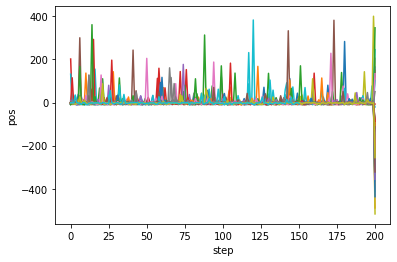

In [231]:
%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.rewards.values():
    plt.plot([o for o in obs])
plt.xlabel("step")
plt.ylabel("pos")

In [0]:
# dqn.load_weights("h5f/my_dqn_weights_try_modify_reward.h5f")


In [220]:
# 学習済モデルに対して、テストを実行 （必要に応じて適切なCallbackも定義、設定可能）
dqn.test(env, nb_episodes=20, visualize=False, callbacks=[cb_ep])

Testing for 20 episodes ...
Episode 1: reward: -589.800, steps: 201
Episode 2: reward: -583.400, steps: 201
Episode 3: reward: -998.800, steps: 201
Episode 4: reward: -518.800, steps: 201
Episode 5: reward: -371.400, steps: 201
Episode 6: reward: -515.800, steps: 201
Episode 7: reward: -0.200, steps: 201
Episode 8: reward: 551.200, steps: 201
Episode 9: reward: 1684.000, steps: 201
Episode 10: reward: -522.400, steps: 201
Episode 11: reward: -707.000, steps: 201
Episode 12: reward: -133.400, steps: 201
Episode 13: reward: 1201.600, steps: 201
Episode 14: reward: -814.600, steps: 201
Episode 15: reward: -758.000, steps: 201
Episode 16: reward: -597.000, steps: 201
Episode 17: reward: -646.000, steps: 201
Episode 18: reward: -8.000, steps: 201
Episode 19: reward: -607.000, steps: 201
Episode 20: reward: 1123.800, steps: 201


Text(0, 0.5, 'pos')

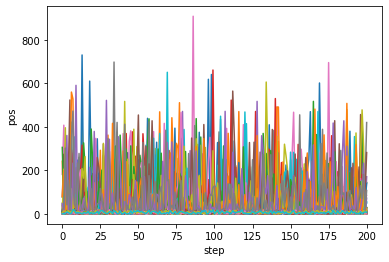

In [221]:
%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o for o in obs])
plt.xlabel("step")
plt.ylabel("pos")

In [222]:
print(cb_ep.actions[0])

[2, 2, 2, 2, 1, 8, 3, 9, 2, 2, 3, 9, 1, 2, 8, 6, 0, 0, 6, 9, 0, 2, 9, 2, 9, 3, 3, 1, 0, 6, 2, 2, 0, 2, 1, 1, 0, 3, 0, 0, 9, 0, 2, 6, 3, 6, 9, 1, 0, 6, 1, 1, 2, 6, 1, 0, 2, 3, 0, 3, 9, 0, 0, 9, 0, 6, 0, 9, 9, 2, 2, 6, 0, 9, 2, 1, 2, 8, 6, 0, 1, 2, 9, 2, 2, 3, 6, 2, 0, 0, 3, 6, 1, 1, 9, 1, 2, 0, 2, 3, 2, 0, 2, 2, 9, 0, 0, 2, 0, 3, 8, 0, 9, 0, 9, 3, 0, 6, 8, 0, 0, 2, 8, 9, 6, 0, 2, 6, 2, 2, 0, 0, 2, 0, 2, 2, 2, 3, 6, 0, 0, 2, 2, 0, 0, 6, 1, 3, 9, 2, 0, 9, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 3, 9, 3, 1, 0, 1, 1, 2, 9, 9, 1, 6, 0, 2, 6, 9, 2, 3, 8, 3, 2, 10, 2, 0, 0, 2, 9, 2, 2, 0, 2, 2, 8, 0, 2, 0, 3, 1, 0]


In [0]:
a  = np.array([1,2,3])
b = np.array([4,5,6])

In [224]:
np.concatenate([[1],b])

array([1, 4, 5, 6])